# Lesson 5: Neural Network Using FastAI library
A notebook based on Lesson 5 of the Fast AI course.

In this notebook, we will repeat the analysis of the titanci dataset that we did from scratch, but this time using the FastAI framework to see what aspects are simpified and abstracted away.

## 0. Set up
Download the source data from Kaggle.

In [1]:
import os
from pathlib import Path
import zipfile

import kaggle


DATA_DIR = Path().absolute().parents[1] / 'datasets' / 'fastai' / 'lesson5'
DATA_FNAME = 'titanic'

if not DATA_DIR.exists():
    kaggle.api.competition_download_cli(str(DATA_FNAME), path=DATA_DIR)
    zipfile.ZipFile(f'{DATA_DIR / DATA_FNAME}.zip').extractall(DATA_DIR)

## 1. Feature engineering
Clean the data, impute missing values and calcualte some meaningful features to train on.

In [2]:
import numpy as np
import pandas as pd

In [3]:
train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
continuous_cols = ['AgeNorm', 'SibSp', 'Parch', 'Family', 'Alone', 'LogFare', 'TicketFreq']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']
    

def calculate_features(df):
    """Add engineered features for the titanic dataset."""
    df = df.copy()

    # Min-max scaler on Age
    df['AgeNorm'] = df['Age'].fillna(df['Age'].mean()) / df['Age'].max()

    # Log of Fares to tame the long tail
    df['LogFare'] = np.log1p(df['Fare'])

    # Group Cabins by Deck
    df['Cabin'].fillna(df['Cabin'].mode().iloc[0], inplace=True)
    df['Deck'] = df['Cabin'].str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG")).fillna("Other")

    # Features based on family members
    df['Family'] = df['SibSp'] + df['Parch']
    df['Alone'] = df['Family'] == 0

    # Did multiple people travel on the same ticket
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')

    # Use just the title portion of the Name field
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('. ', expand=True)[0]
    df['Title'] = df['Title'].map({'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master'}).fillna("Other")

    # One-hot encode categorical variables
    categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']
    df['Embarked'].fillna(df['Embarked'].mode().iloc[0], inplace=True)
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    df['const'] = 1

    # Filter the output columns
    categorical_cols_output = []
    for cat_col in categorical_cols:
        categorical_cols_output.extend([k for k in df.columns if f'{cat_col}_' in k])
    output_cols = continuous_cols + categorical_cols_output

    return df[output_cols] * 1.

In [6]:
X_train = calculate_features(train_df)
X_train.head()

,AgeNorm,SibSp,Parch,Family,Alone,LogFare,TicketFreq,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_DE,Deck_FG,Deck_Other,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0.2750,1.0,0.0,1.0,0.0,2.110213,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.4750,1.0,0.0,1.0,0.0,4.280593,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.3250,0.0,0.0,0.0,1.0,2.188856,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.4375,1.0,0.0,1.0,0.0,3.990834,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.4375,0.0,0.0,0.0,1.0,2.202765,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
y_train = train_df['Survived'] * 1.
y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

## 2. Use FastAI framework to train a model

### 2.1. Training/validation split

In [8]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [19]:
full_df = pd.concat([X_train, y_train.to_frame('Survived')], axis=1)
full_df

,AgeNorm,SibSp,Parch,Family,Alone,LogFare,TicketFreq,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_DE,Deck_FG,Deck_Other,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Survived
0,0.28,1.00,0.00,1.00,0.00,2.11,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,0.47,1.00,0.00,1.00,0.00,4.28,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
2,0.33,0.00,0.00,0.00,1.00,2.19,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
3,0.44,1.00,0.00,1.00,0.00,3.99,2.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
4,0.44,0.00,0.00,0.00,1.00,2.20,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.34,0.00,0.00,0.00,1.00,2.64,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
887,0.24,0.00,0.00,0.00,1.00,3.43,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
888,0.37,1.00,2.00,3.00,0.00,3.20,2.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
889,0.33,0.00,0.00,0.00,1.00,3.43,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00


In [21]:
splits = RandomSplitter(seed=42)(full_df)
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

### 2.2. Create a learner

In [22]:
full_df.columns

Index(['AgeNorm', 'SibSp', 'Parch', 'Family', 'Alone', 'LogFare', 'TicketFreq',
       'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Deck_DE', 'Deck_FG', 'Deck_Other', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other', 'Survived'],
      dtype='object')

In [23]:
dls = TabularPandas(
    full_df,
    splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex_male",
               "Pclass_2", "Pclass_3", 
               "Embarked_Q", "Embarked_S",
               "Deck_DE", "Deck_FG",
               'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other'],
    cont_names=['AgeNorm', 'SibSp', 'Parch', 'Family', 'Alone', 'LogFare', 'TicketFreq'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

In [29]:
learn = tabular_learner(dls, metrics=accuracy, layers=[20,10, 5])

SuggestedLRs(slide=0.10000000149011612, valley=0.013182567432522774)

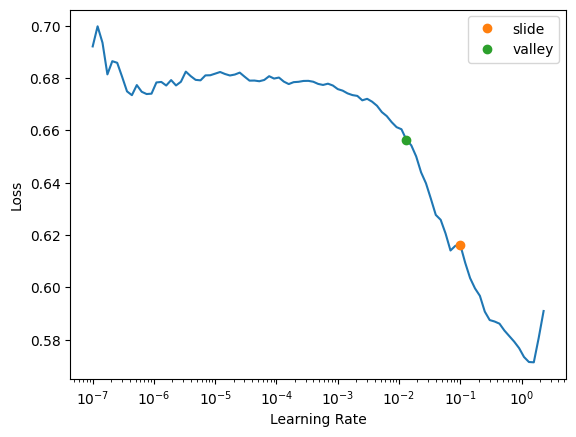

In [30]:
learn.lr_find(suggest_funcs=(slide, valley))

In [31]:
learn.fit(16, lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.559134,0.605601,0.780899,00:00
1,0.503524,0.478018,0.825843,00:00
2,0.469297,0.491458,0.780899,00:00
3,0.450447,0.449769,0.814607,00:00
4,0.434195,0.429424,0.820225,00:00
5,0.429142,0.408985,0.831461,00:00
6,0.419339,0.411553,0.825843,00:00
7,0.410984,0.419833,0.797753,00:00
8,0.400281,0.422964,0.837079,00:00
9,0.395703,0.425158,0.831461,00:00


### 2.3. Submit to Kaggle

In [33]:
test_df['Fare'] = test_df['Fare'].fillna(0)
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.05,NaN,S


In [34]:
test_df_features = calculate_features(test_df)
test_df_features

,AgeNorm,SibSp,Parch,Family,Alone,LogFare,TicketFreq,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_DE,Deck_FG,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0.45,0.00,0.00,0.00,1.00,2.18,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,0.62,1.00,0.00,1.00,0.00,2.08,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
2,0.82,0.00,0.00,0.00,1.00,2.37,1.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,0.36,0.00,0.00,0.00,1.00,2.27,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4,0.29,1.00,1.00,2.00,0.00,2.59,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.40,0.00,0.00,0.00,1.00,2.20,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
414,0.51,0.00,0.00,0.00,1.00,4.70,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
415,0.51,0.00,0.00,0.00,1.00,2.11,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
416,0.40,0.00,0.00,0.00,1.00,2.20,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00


In [36]:
test_dl = learn.dls.test_dl(test_df_features)

In [37]:
learn.get_preds?

Signature:
learn.get_preds(
    ds_idx: 'int' = 1,
    dl=None,
    with_input: 'bool' = False,
    with_decoded: 'bool' = False,
    with_loss: 'bool' = False,
    act=None,
    inner: 'bool' = False,
    reorder: 'bool' = True,
    cbs: 'Callback | MutableSequence | None' = None,
    *,
    save_preds: 'Path' = None,
    save_targs: 'Path' = None,
    with_preds: 'bool' = True,
    with_targs: 'bool' = True,
    concat_dim: 'int' = 0,
    pickle_protocol: 'int' = 2,
) -> 'tuple'
Docstring: Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`
File:      ~/miniconda3/envs/ml-practice/lib/python3.11/site-packages/fastai/learner.py
Type:      method

In [38]:
predictions, _ = learn.get_preds(dl=test_dl)

In [39]:
predictions

tensor([[0.9738, 0.0262],
        [0.5398, 0.4602],
        [0.9960, 0.0040],
        [0.9199, 0.0801],
        [0.3797, 0.6203],
        [0.8843, 0.1157],
        [0.2500, 0.7500],
        [0.9868, 0.0132],
        [0.2401, 0.7599],
        [0.9199, 0.0801],
        [0.9263, 0.0737],
        [0.9179, 0.0821],
        [0.0157, 0.9843],
        [0.9895, 0.0105],
        [0.0197, 0.9803],
        [0.0309, 0.9691],
        [0.9850, 0.0150],
        [0.8340, 0.1660],
        [0.7324, 0.2676],
        [0.4204, 0.5796],
        [0.8993, 0.1007],
        [0.1162, 0.8838],
        [0.0428, 0.9572],
        [0.7572, 0.2428],
        [0.1991, 0.8009],
        [0.9660, 0.0340],
        [0.0315, 0.9685],
        [0.8450, 0.1550],
        [0.9040, 0.0960],
        [0.8733, 0.1267],
        [0.9873, 0.0127],
        [0.9756, 0.0244],
        [0.6017, 0.3983],
        [0.5755, 0.4245],
        [0.7441, 0.2559],
        [0.8143, 0.1857],
        [0.7346, 0.2654],
        [0.6634, 0.3366],
        [0.9

In [57]:
output_df = test_df.copy()
output_df['Survived'] = (predictions[:,1] > 0.5).int()
output_df = output_df[['PassengerId', 'Survived']]
output_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [58]:
output_df['Survived'].value_counts()

Survived
0    271
1    147
Name: count, dtype: int64

In [59]:
output_df.to_csv('nn_model_framework_output.csv', index=False)

## 3. Ensembling
We can create models easily now, so let's create several and average them together for a better model.

### 3.1. Create multiple models

In [61]:
def create_model_and_get_preds(layers):
    """Create a model with the given `layers` architecture and return the model predictions"""
    learn = tabular_learner(dls, metrics=accuracy, layers=layers)
    with learn.no_bar(), learn.no_logging():
        learn.fit(20, lr=0.03)
    return learn.get_preds(dl=test_dl)[0]

In [62]:
model_architectures = (
    [10],
    [20],
    [10, 10],
    [10, 20],
    [20, 10],
    [10, 10, 10],
    [10, 15, 20],
)

In [63]:
learns = [create_model_and_get_preds(layers) for layers in model_architectures]

In [66]:
len(learns)

7

In [67]:
learns[0].shape

torch.Size([418, 2])

In [68]:
ensemble_preds = torch.stack(learns).mean(0)

In [69]:
ensemble_preds

tensor([[0.9280, 0.0720],
        [0.5737, 0.4263],
        [0.9734, 0.0266],
        [0.9053, 0.0947],
        [0.2969, 0.7031],
        [0.8826, 0.1174],
        [0.2883, 0.7117],
        [0.9630, 0.0370],
        [0.2001, 0.7999],
        [0.9383, 0.0617],
        [0.9135, 0.0865],
        [0.8697, 0.1303],
        [0.0305, 0.9695],
        [0.9580, 0.0420],
        [0.0184, 0.9816],
        [0.0227, 0.9773],
        [0.9536, 0.0464],
        [0.8358, 0.1642],
        [0.6469, 0.3531],
        [0.4063, 0.5937],
        [0.8598, 0.1402],
        [0.1428, 0.8572],
        [0.0707, 0.9293],
        [0.7897, 0.2103],
        [0.1954, 0.8046],
        [0.9671, 0.0329],
        [0.0288, 0.9712],
        [0.8417, 0.1583],
        [0.8431, 0.1569],
        [0.8544, 0.1456],
        [0.9507, 0.0493],
        [0.9589, 0.0411],
        [0.4854, 0.5146],
        [0.4581, 0.5419],
        [0.7345, 0.2655],
        [0.8254, 0.1746],
        [0.6142, 0.3858],
        [0.5439, 0.4561],
        [0.9

### 3.2. Submit to Kaggle

In [70]:
output_df = test_df.copy()
output_df['Survived'] = (ensemble_preds[:,1] > 0.5).int()
output_df = output_df[['PassengerId', 'Survived']]
output_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [71]:
output_df['Survived'].value_counts()

Survived
0    260
1    158
Name: count, dtype: int64

In [72]:
output_df.to_csv('nn_model_ensemble_output.csv', index=False)